In [1]:
# All necessary imports

import numpy as np
import pandas as pd
import os

import matplotlib.cm as cm 
%matplotlib inline

import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torchvision.models as models

torch.manual_seed(42)
torch.cuda.set_per_process_memory_fraction(0.5)

import dill

##### Data Preprocessing

In [2]:
# dill.load_session('state.db')

In [3]:
# Importing the dataset

train_dir = "/kaggle/input/100-bird-species/train"
valid_dir = "/kaggle/input/100-bird-species/valid"
test_dir = "/kaggle/input/100-bird-species/test" 

In [4]:
# Determining the number of folders in the dataset
print("Number of folders in train, valid and test dataset:", len(os.listdir(train_dir)),",", len(os.listdir(valid_dir)),",", len(os.listdir(test_dir)))

Number of folders in train, valid and test dataset: 525 , 525 , 525


In [5]:
# Function to count the number of images in the folder

def count_images(folder_path):
     total_images = 0
     for root, dirs, files in os.walk(folder_path):
          for file in files:
               if file.lower().endswith('.jpg'):
                    total_images += 1

     return total_images

print("The total number of training images:", count_images(train_dir))
print("The total number of testing images:", count_images(test_dir))
print("The total number of validation images:", count_images(valid_dir))

The total number of training images: 84635
The total number of testing images: 2625
The total number of validation images: 2625


In [6]:
# Function to return the list of all image classes

def class_names(folder_path):
     classes = [f.name for f in os.scandir(folder_path) if f.is_dir()]
     return classes

class_names = class_names(train_dir)
class_names

['DALMATIAN PELICAN',
 'BLACK BREASTED PUFFBIRD',
 'WATTLED CURASSOW',
 'AMERICAN WIGEON',
 'CARMINE BEE-EATER',
 'GAMBELS QUAIL',
 'UMBRELLA BIRD',
 'AMERICAN KESTREL',
 'AMERICAN GOLDFINCH',
 'BLUE GROSBEAK',
 'PALM NUT VULTURE',
 'DUSKY LORY',
 'AUCKLAND SHAQ',
 'BLACK THROATED WARBLER',
 'YELLOW CACIQUE',
 'STRIPPED SWALLOW',
 'VERMILION FLYCATHER',
 'CAPE MAY WARBLER',
 'RED TAILED HAWK',
 'GURNEYS PITTA',
 'INDIAN ROLLER',
 'SNOW GOOSE',
 'GREEN WINGED DOVE',
 'AZURE TANAGER',
 'GREEN MAGPIE',
 'BANDED BROADBILL',
 'AFRICAN PYGMY GOOSE',
 'INDIGO FLYCATCHER',
 'GREY PLOVER',
 'TOUCHAN',
 'HYACINTH MACAW',
 'HARLEQUIN DUCK',
 'ABYSSINIAN GROUND HORNBILL',
 'CALIFORNIA QUAIL',
 'BALD IBIS',
 'WOOD THRUSH',
 'RUBY THROATED HUMMINGBIRD',
 'INDIGO BUNTING',
 'ALBERTS TOWHEE',
 'SORA',
 'HOODED MERGANSER',
 'ROSEATE SPOONBILL',
 'CAPE ROCK THRUSH',
 'BLUE COAU',
 'CALIFORNIA CONDOR',
 'BORNEAN PHEASANT',
 'BARN SWALLOW',
 'TAIWAN MAGPIE',
 'SPLENDID WREN',
 'RED BILLED TROPICBIRD',
 'B

##### Visualization of images from the dataset

In [7]:
train_dir_list = [train_dir + "/" + x for x in class_names]

tx = []

for dir_path in train_dir_list:
    tx.extend([dir_path + '/' + x for x in os.listdir(dir_path)])

In [8]:
def extract_capitalized_words(input_string):
    path = input_string.split('/')[-2]
    return path

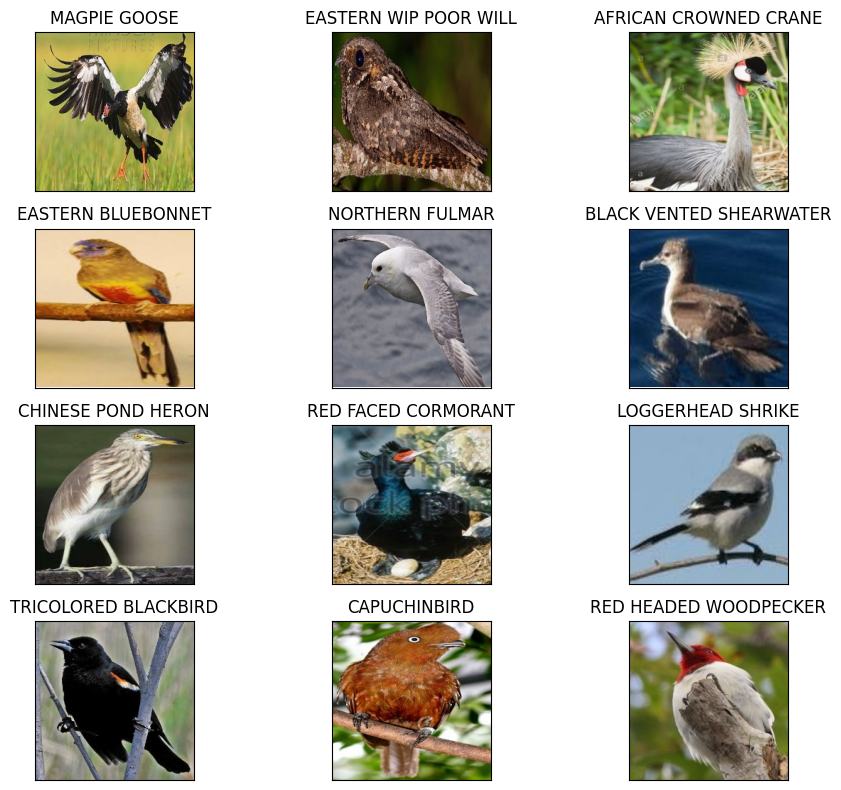

In [9]:
# Display 12 picture of the dataset with their labels

random_index = np.random.randint(0, len(tx), 12)

fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (10, 8),
                         subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(tx[random_index[i]]))
    ax.set_title(extract_capitalized_words(tx[random_index[i]]))
    
plt.tight_layout()
plt.show()

In [10]:
# Generating batches of image files from the directory

img_width = 224
img_height = 224
img_size = (224, 224)

data_dir = "Datasets"

# Data Augmentation

train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(0.2),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])


train_dataset = ImageFolder(root = train_dir, transform = train_transforms)
valid_dataset = ImageFolder(root = valid_dir, transform = valid_transforms)

train_loader = DataLoader(train_dataset,
                        batch_size = 32,
                        shuffle = True,
                        pin_memory = True,
                        num_workers = 4)

valid_loader = DataLoader(valid_dataset,
                        batch_size = 32,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = 4)

##### Model

In [11]:
# Model creation
class Net(nn.Module):
     def __init__(self):
        super(Net, self).__init__()
        
        # Load the pretrained EfficientNet-B0 model
        self.efficientnet = models.efficientnet_b0(pretrained = True)
        
        # Remove the final classification layer
        self.efficientnet.classifier = nn.Identity()
        
        # Adaptive pooling to get a fixed-size output
        # self.poolnet = nn.AdaptiveAvgPool((7, 7))
        
        # Custom convolutional layers
        # self.conv1 = nn.Conv2d(in_channels = 1280, out_channels = 64, kernel_size = 1)
        # self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3)
        # self.pool = nn.MaxPool2d(kernel_size = (2, 2)) 
        
        #self.fc1 = nn.Linear(32*26*26, 1024)
        
        self.fc1 = nn.Linear(1280, 1024)
        self.fc2 = nn.Linear(1024, 525)
        
        
        self.dropout = nn.Dropout(0.5)

     def forward(self, x):
        x = self.efficientnet(x)
        
        # EfficientNet outputs a 2D feature map, we need to unsqueeze to add a channel dimension
        #x = x.unsqueeze(2).unsqueeze(3)
        
        # Apply adaptive pooling to get a fixed-size feature map
        # x = self.poolnet(x)
        
        # Pass through custom convolutional layers
        #x = self.pool(nn.functional.relu(self.conv1(x)))
        #x = self.pool(nn.functional.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Pass through fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 1e-3

model = Net()

model = model.to(device)

print(model)

#Define the loss function
criterion = nn.CrossEntropyLoss()

#Define optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

#Count the total number of parameters

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

#Define accuracy metric function
def accuracy(y_pred, y_true):
     y_pred = torch.round(y_pred)
     correct = (y_pred == y_true).sum().item()
     return correct / len(y_true)

#Define the callback

class EarlyStopping:
     def __init__(self, patience = 5, min_delta = 0.01):
          self.patience = patience
          self.min_delta = min_delta
          self.counter = 0
          self.best_score = None
          self.early_stop = False

     def __call__(self, val_metric):
          if self.best_score is None:
               self.best_score = val_metric
          elif val_metric < self.best_score - self.min_delta:
               self.counter += 1
               if self.counter >= self.patience:
                    self.early_stop = True
          else:
               self.best_score = val_metric
               self.counter = 0

early_stopping = EarlyStopping(patience = 2, min_delta = 0.01)

#Define the ReduceLROnPlateaou scheduler to adjust the learning rate on the basis of the validation performance

reduce_lr_scheduler = ReduceLROnPlateau(optimizer, 
                                        mode = 'max', 
                                        factor = 0.1, 
                                        patience = 2,  
                                        threshold_mode = 'abs', 
                                        cooldown = 0,
                                        min_lr = 0,
                                        eps = 1e-08,
                                        )


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]


Net(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_acti

##### Model training and evaluation

In [2]:
# Save model and save plots

def save_model(epochs, model, optimizer, criterion, path='model.pth'):
    # Create a dictionary to store model state and other info
    model_info = {
        'epochs': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'criterion_state_dict': criterion.state_dict(),
    }
    # Save the dictionary
    torch.save(model_info, path)
    print(f'Model saved to {path}')

def save_plots(train_stats_acc, valid_stats_acc, train_stats_loss, valid_stats_loss, path_acc='accuracy_plot.png', path_loss='loss_plot.png'):
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_stats_acc, label='Training Accuracy')
    plt.plot(valid_stats_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(path_acc)
    plt.close()
    print(f'Accuracy plot saved to {path_acc}')
    
    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_stats_loss, label='Training Loss')
    plt.plot(valid_stats_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(path_loss)
    plt.close()
    print(f'Loss plot saved to {path_loss}')

In [3]:
train_stats_loss, valid_stats_loss, train_stats_acc, valid_stats_acc = [], [], [], []

In [1]:
#Learning_parameters

lr = 1e-1
epochs = 10
device = ("cuda" if torch.cuda.is_available() else 'cpu')

for epoch in range(epochs):
     #Training the model
     model.train()
     print('Training')
     train_loss = 0.0
     train_running_correct = 0
     counter = 0
     for i, data in tqdm(enumerate(train_loader), total = len(train_loader)):
          counter += 1
          image, labels = data
          image = image.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          #Forward pass
          outputs = model(image)
          
          #Calculate the loss
          loss = criterion(outputs, labels)
          train_loss += loss.item()

          #Calculate the accuracy
          _, preds = torch.max(outputs.data, 1)

          train_running_correct += (preds == labels).sum().item()

          #Backpropagation
          loss.backward()
          #Update the optimizer parameters
          optimizer.step()
          
     epoch_loss_train = train_loss / counter
     epoch_acc_train = 100. * (train_running_correct / len(train_loader.dataset))
     
     # Print epoch statistics
     print(f"Epoch {epoch+1}/{20}, Train Loss : {epoch_loss_train:.6f}, Train Accuracy: {epoch_acc_train:.6f}")
     
     # Loss and Accuracy Statistics
     
     train_stats_loss.append(epoch_loss_train)
     train_stats_acc.append(epoch_acc_train)
    
     #Validating the model
     model.eval()
     print('Validation')
     valid_loss = 0.0
     valid_running_correct = 0
     counter = 0
     with torch.no_grad():
          for i, data in tqdm(enumerate(valid_loader), total = len(valid_loader)):
               counter += 1
               image, labels = data
               image, labels = image.to(device), labels.to(device)

               #Forward pass
               outputs = model(image)

               #Calculate the loss
               loss = criterion(outputs, labels)
               valid_loss += loss.item()

               #calculate the accuracy
               _, preds = torch.max(outputs.data, 1)
               valid_running_correct += (preds == labels).sum().item()
     
     #Loss and accuracy for the complete epoch
     epoch_loss_valid = valid_loss / counter
     epoch_acc_valid = 100. * (valid_running_correct / len (valid_loader.dataset))
     
     #Print epoch statistics
     print(f"Epoch {epoch+1}/{20}, Validation Loss : {epoch_loss_valid:.6f}, Validation Accuracy: {epoch_acc_valid:.6f}")
     
     # Loss Statistics
     valid_stats_loss.append(epoch_loss_valid)
     valid_stats_acc.append(epoch_acc_valid)
        
     #Check early stopping criteria
     early_stopping(epoch_acc_train)
     if early_stopping.early_stop:
          print("Early Stopping")
          
          # Get the last learning rate used by the optimizer
          last_lr = optimizer.param_groups[0]['lr']
          print("Last learning rate:", last_lr)
          break


# Save the model
save_model(epochs, model, optimizer, criterion)

# Save the loss and accruacy plots
save_plots(train_stats_acc, valid_stats_acc, train_stats_loss, valid_stats_loss)

print("Training Complete")

Training


  0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 1/20, Train Loss : 5.497318, Train Accuracy: 10.761505
Validation


  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 1/20, Validation Loss : 5.415638, Validation Accuracy: 21.447619
Early Stopping
Last learning rate: 0.001
Model saved to model.pth
Accuracy plot saved to accuracy_plot.png
Loss plot saved to loss_plot.png
Training Complete


Test Model

In [ ]:
# Test Loader
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])


test_dataset = ImageFolder(root = test_dir, transform = test_transforms)

test_loader = DataLoader(test_dataset,
                        batch_size = 32,
                        shuffle = False,
                        pin_memory = True,
                        num_workers = 4)

In [ ]:
def test(model):
    test_loss = 0.0
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))
    
    model.eval()
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total = len(test_loader)):
            counter += 1
            device = ("cuda" if torch.cuda.is_available() else 'cpu')
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(image)
            loss = criterion(outputs, labels)

            #Calculate the loss
            test_loss += loss.item()

            #calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()
        
        #Loss and accuracy for the complete epoch
        epoch_loss_test = test_loss / counter
        epoch_acc_test = 100. * (test_running_correct / len (test_loader.dataset))
     
        for i in range(len(class_names)):
            if class_total[i] > 0:
                print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              class_names[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

        print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
test(model)

In [ ]:
dill.dump_session('state.db')